Probabilistic inversion is a technique used to estimate unknown parameters of a physical model by incorporating the uncertainty present in both the data and the model itself. Unlike deterministic methods, which yield a single "best-fit" solution, probabilistic inversion provides a probability distribution for each parameter, reflecting the range and likelihood of possible values.

## Key Concepts

- **Uncertainty:** Real-world measurements and models are never perfect. Probabilistic inversion explicitly accounts for these uncertainties, leading to more robust and informative results.
- **Parameter Estimation:** Instead of finding just one set of parameters, we estimate how likely different parameter values are, given the observed data.
- **Probability Distribution:** The result is not a single answer, but a distribution that shows which parameter values are more or less probable.

## Grid Search Approach

Grid search is a straightforward way to perform probabilistic inversion:

1. **Define Parameter Ranges:** Choose the parameters to estimate and specify the range and step size for each.
2. **Generate Parameter Combinations:** Create a grid of all possible combinations of parameter values.
3. **Simulate and Compare:** For each combination, run the model and compare its output to the observed data.
4. **Compute Likelihood:** Calculate how well each parameter set matches the data (e.g., using mean squared error or another criterion).
5. **Build Probability Distributions:** Assign probabilities to each parameter set based on their likelihood, resulting in a probability distribution over the parameter space.

## Marginal Distributions

- **1D Marginal Distribution:** Shows the probability distribution of a single parameter, integrating (summing) over all other parameters. This helps you understand the uncertainty and most likely values for each parameter individually.
- **2D Marginal Distribution:** Shows the joint probability distribution for two parameters at a time, revealing possible correlations or dependencies between them.



In [29]:
%reset -f 
Station="IntD"
# This script is used to generate a grid search for the IntD station
# name file Station+grid_search.py
name_file = Station + "_grid_search.py"
with open(name_file, "w") as f:
    pass

In [30]:
# -*- coding: utf-8 -*-

"""
Created on Wed Oct 18 14:57:23 2023
import functions mesh
"""
dir_ginette = "/home/ariviere/Programmes/ginette"
# RIV2D + Station

import os
main_dir = os.path.join(dir_ginette, "application/RIV2D", Station)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import math
import matplotlib.pyplot as plt
# Ajouter le chemin du dossier src au PYTHONPATH
import importlib
sys.path.append(dir_ginette)  # Ajouter le dossier parent de src

# use __init__.py to import all functions/ in src/src_gmsh and src/src_pythont
# insure 
from src.src_gmsh import mesh_generator
from src.src_python import Init_folders
from src.src_python import Direct_model
from src.src_python import Read_obs
from src.src_python import Plot
from src.src_python import stat_critere
from src.src_python import Grid_search

# Import all functions/classes from the relevant modules
from src.src_gmsh.mesh_generator import *
from src.src_python.Init_folders import *
from src.src_python.Direct_model import *
from src.src_python.Read_obs import *
from src.src_python.Plot import *
from src.src_python.stat_critere import *
from src.src_python.Grid_search import *
import importlib


importlib.reload(Init_folders)
importlib.reload(Direct_model)
importlib.reload(Grid_search)

# give me all names of the functions in Init_folders
#print(Init_folders.__dict__)
#print([name for name in dir(Init_folders) if callable(getattr(Init_folders, name)) and not name.startswith("__")])



<module 'src.src_python.Grid_search' from '/home/ariviere/Programmes/ginette/src/src_python/Grid_search.py'>

# Using generate_grid_search_table for Grid Search

The function generate_grid_search_table helps you create a DataFrame containing all possible combinations of parameter values for the specified zones and parameters. This is useful for systematically exploring parameter spaces in grid search optimization.

#### How to Use

1. **Define the zones to invert:**  
List the zone numbers you want to include in the grid search.
```python
zones_to_invert = [4, 5]
```

2. **Specify the parameters to invert:**  
List the parameter names (as strings) you want to vary.
```python
parameters = ['k', 'n']
```

3. **Set the parameter ranges:**  
Use a dictionary where each key is a zone number, and each value is another dictionary mapping parameter names to their ranges.  
Each range can be:
- A tuple `(min, max, step)` for generating values with `np.arange`
- A list of explicit values

#### Example:
```python
param_ranges = {
     4: {'k': (-12, -10.5, 2), 'n': (0.01, 0.1, 0.1)},
     5: {'k': (-15, -11, 4), 'n': (0.3, 0.8, 0.7)}
}
```

4. **Generate the parameter table:**  
Call the function with your zones, parameters, and ranges.
```python
param_table = generate_grid_search_table(zones_to_invert, parameters, param_ranges)
```

5. **View the results:**  
The resulting `param_table` is a pandas DataFrame. You can display the first few rows:
```python
print(param_table.head())
```

### Example Output

            |   k4   |   n4   |  k5  |  n5  |
            |--------|--------|------|------|
            | -12.0  | 0.01   | -15  | 0.3  |
            | -12.0  | 0.01   | -15  | 1.0  |
            | -12.0  | 0.01   | -11  | 0.3  |
            | ...    | ...    | ...  | ...  |

This table contains all combinations of the specified parameter values for each zone. Use it to run simulations or analyses for each parameter set.


In [31]:

# Reload the Grid_search module to ensure any recent changes are reflected
importlib.reload(Grid_search)

# Set the simulation start date (background date for the simulation)
date_simul_bg = pd.to_datetime("2016/09/19 12:00:00")

# Station name is already defined in the notebook as 'Station'
Station = Station

# List of sensor names used for temperature measurements
sensors = ["Temp_1", "Temp_2", "Temp_3", "Temp_4", "Temp_5", "Temp_6", "Temp_7", "Temp_8"]

# Load observed temperature data from CSV file
obs_temp = pd.read_csv("Obs_temp_PT100_t.dat", sep=",", header=0)

# Convert each sensor column to numeric, coercing errors to NaN
for i in range(len(sensors)):
    obs_temp[sensors[i]] = pd.to_numeric(obs_temp[sensors[i]], errors='coerce')

# Ensure the 'Time' column is numeric (in seconds)
obs_temp['Time'] = pd.to_numeric(obs_temp['Time'], errors='coerce')

# Convert the 'dates' column to datetime objects for time series analysis
obs_temp['dates'] = pd.to_datetime(obs_temp['dates'], format='%Y-%m-%d %H:%M:%S')

# Display the first few rows of the loaded and processed data
obs_temp.head()

# List of parameter names for each zone (used in parameter tables)
param_struct = ['zone', 'k', 'n', 'l', 'cpm', 'r']

# Define subdirectories for storing sensitivity, output, and parameter files
subdirectories = ['SENSI', 'OUTPUT', 'PARAMETER']

# Append the station name to each subdirectory for organization
for i in range(len(subdirectories)):
    subdirectories[i] = subdirectories[i] + "_" + Station
    print(subdirectories[i])

# Prepare the Ginette simulation directories (creates folders if needed)
prepare_ginette_directories(main_dir, subdirectories=subdirectories)

# Change the working directory to the main simulation directory
os.chdir(main_dir)

# Compile the Ginette source code (if needed for the simulation)
compile_ginette_src(dir_ginette)

# Set the measurement uncertainty (standard deviation of temperature measurements)
sigma = 0.2

# Define the zones where parameters will be inverted (calibrated)
zones_to_invert = [4, 5]

# Define which parameters will be inverted for each zone
parameters_to_invert = ['k', 'n']



# Define the range (min, max, step) for each parameter in each zone
param_ranges = {
    4: {'k': (-12.5, -10.5, 1), 'n': (0.01, 0.1, 0.04)},
    5: {'k': (-15, -11, 2), 'n': (0.25, 0.8, 0.25)}
}

# Generate a table (DataFrame) with all combinations of parameters for the grid search
param_table = generate_grid_search_table(zones_to_invert, parameters_to_invert, param_ranges)

# Print the total number of simulations that will be run
print(f"Nombre de simulations : {len(param_table)}")




# Afficher les premières lignes du tableau
print(param_table.head(100))

simul_todo = range(1, 83)
# create input_inversion.txt file to have all parameter needed for the inversion i.e date_simul_bg, sigma, zones_to_invert, parameters_to_invert, param_ranges
with open("input_inversion.txt", "w") as f:
    f.write(f"date_simul_bg: {date_simul_bg.strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Station: {Station}\n")
    f.write(f"param_struct: {', '.join([repr(x) for x in param_struct])}\n")
    f.write(f"sensors: {', '.join([repr(x) for x in sensors])}\n")
    f.write(f"sigma: {sigma}\n")
    f.write(f"zones_to_invert: {', '.join(str(z) for z in zones_to_invert)}\n")
    f.write(f"parameters_to_invert: {', '.join([repr(x) for x in parameters_to_invert])}\n")
    f.write(f"simul_todo: {simul_todo.start}, {simul_todo.stop}\n")
    f.write(f"path_simul: {main_dir}\n")
    f.write(f"dir_ginette: {dir_ginette}\n")

# create a param_table.txt file
param_table.to_csv("param_table.txt", sep=",", index=False)


SENSI_IntD
OUTPUT_IntD
PARAMETER_IntD
Current working directory: /home/ariviere/Programmes/ginette/application/RIV2D/IntD
Directory 'SENSI_IntD' already exists.
Directory 'OUTPUT_IntD' already exists.
Directory 'PARAMETER_IntD' already exists.
ginette exists
Zone 4, Parameter 'k': Values = [-12.5 -11.5 -10.5]
Zone 4, Parameter 'n': Values = [0.01  0.055 0.1  ]
Zone 5, Parameter 'k': Values = [-15. -13. -11.]
Zone 5, Parameter 'n': Values = [0.25  0.525 0.8  ]
Nombre de simulations : 81
      k4    n4    k5     n5
0  -12.5  0.01 -15.0  0.250
1  -12.5  0.01 -15.0  0.525
2  -12.5  0.01 -15.0  0.800
3  -12.5  0.01 -13.0  0.250
4  -12.5  0.01 -13.0  0.525
..   ...   ...   ...    ...
76 -10.5  0.10 -13.0  0.525
77 -10.5  0.10 -13.0  0.800
78 -10.5  0.10 -11.0  0.250
79 -10.5  0.10 -11.0  0.525
80 -10.5  0.10 -11.0  0.800

[81 rows x 4 columns]


In [32]:
# remove IntD_grid_search.py
name_file = Station + "_grid_search.py"
os.remove(name_file)

In [33]:
%%writefile  IntD_grid_search.py

import os
import sys
# read the input_inversion.txt file#%%writefile IntD_grid_search.py
with open("input_inversion.txt", "r") as f:
    lines = f.readlines()

# Helper to parse a line of the form "key: value"
def parse_line(line):
    key, value = line.strip().split(":", 1)
    return key.strip(), value.strip()

parsed = dict(parse_line(line) for line in lines)

date_simul_bg = parsed["date_simul_bg"]
Station = parsed["Station"]
# Read param_struct from the parsed input and convert to list
param_struct = [x.strip(" '") for x in parsed["param_struct"].split(",")]
sensors = [x.strip(" '") for x in parsed["sensors"].split(",")]
sigma = float(parsed["sigma"])
zones_to_invert = [int(z) for z in parsed["zones_to_invert"].strip("[]").split(",")]
parameters_to_invert = [x.strip(" '") for x in parsed["parameters_to_invert"].split(",")]
simul_todo_range = parsed["simul_todo"].split(",")
simul_todo = range(int(simul_todo_range[0]), int(simul_todo_range[1]))
main_dir = parsed["path_simul"]
dir_ginette = parsed["dir_ginette"]

os.chdir(main_dir)





import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import math
import matplotlib.pyplot as plt
# Ajouter le chemin du dossier src au PYTHONPATH
import importlib
sys.path.append(dir_ginette)  # Ajouter le dossier parent de src

# use __init__.py to import all functions/ in src/src_gmsh and src/src_pythont
# insure 
from src.src_gmsh import mesh_generator
from src.src_python import Init_folders
from src.src_python import Direct_model
from src.src_python import Read_obs
from src.src_python import Plot
from src.src_python import stat_critere
from src.src_python import Grid_search

# Import all functions/classes from the relevant modules
from src.src_gmsh.mesh_generator import *
from src.src_python.Init_folders import *
from src.src_python.Direct_model import *
from src.src_python.Read_obs import *
from src.src_python.Plot import *
from src.src_python.stat_critere import *
from src.src_python.Grid_search import *
import importlib


importlib.reload(Init_folders)
importlib.reload(Direct_model)
importlib.reload(Grid_search)
from src.src_python.Grid_search import *
from src.src_python import Grid_search
importlib.reload(Grid_search)

# Convert the date_simul_bg to datetime
date_simul_bg = pd.to_datetime(date_simul_bg, format='%Y-%m-%d %H:%M:%S')
print(f"date_simul_bg: {date_simul_bg}")
print(f"Station: {Station}")
print(f"param_struct: {param_struct}")
print(f"sensors: {sensors}")
print(f"sigma: {sigma}")
print(f"zones_to_invert: {zones_to_invert}")
print(f"parameters_to_invert: {parameters_to_invert}")
print(f"simul_todo: {simul_todo}")
print(f"path_simul: {main_dir}")
print(f"dir_ginette: {dir_ginette}")


# read the param_table.txt file
param_table = pd.read_csv("param_table.txt", sep=",", header=0)

# Load observed temperature data from CSV file
obs_temp = pd.read_csv("Obs_temp_PT100_t.dat", sep=",", header=0)

# Convert each sensor column to numeric, coercing errors to NaN
for i in range(len(sensors)):
    obs_temp[sensors[i]] = pd.to_numeric(obs_temp[sensors[i]], errors='coerce')

# Ensure the 'Time' column is numeric (in seconds)
obs_temp['Time'] = pd.to_numeric(obs_temp['Time'], errors='coerce')

# Convert the 'dates' column to datetime objects for time series analysis
obs_temp['dates'] = pd.to_datetime(obs_temp['dates'], format='%Y-%m-%d %H:%M:%S')

param_table['index_sim'] = param_table.index + 1
# header 'index_sim'+ colname of parameter
header_save_param = param_table.columns
# Table of simulated parameters
# param_table = pd.DataFrame(columns=header_save_param)
param_table_simul = pd.DataFrame(columns=header_save_param)


#mse_table empty dataframe
# mse_table has columns: index_sim, Temp_1, Temp_2, ..., Temp_8, Total_mse
mse_table = pd.DataFrame(columns=['index_sim'] + sensors + ['Total_mse'])

# make a loop to run each index_sim in simul_todo
for id_sim in simul_todo:
    mse, param_table_id_sim = run_one_simulation_2D(
        Station, main_dir, date_simul_bg, obs_temp, sensors,
        param_table, id_sim, param_struct, zones_to_invert,
        parameters_to_invert, param_table_simul, sigma
    )
    # mse is a DataFrame with columns: Temp_1, ..., Temp_8, Total_mse
    mse['index_sim'] = id_sim
    mse_table = pd.concat([mse_table, mse], ignore_index=True)
    param_table_simul = pd.concat([param_table_simul, param_table_id_sim], ignore_index=True)

# add the column of parameter in the table mse_table
for param in header_save_param:
    mse_table[param] = param_table_simul[param].values

mse_table.to_csv("SENSI_" + Station + "/"+ "S_mse_simul.dat", index=False)

Writing IntD_grid_search.py


In [16]:

# Read mse_file
mse_table = pd.read_csv("SENSI_" + Station + "/"+ "S_mse_simul.dat", sep=",", header=0)

mse_table.head(10)

,index_sim,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,Temp_6,Temp_7,Temp_8,Total_mse,k4,n4,k5,n5
0,1,76558.455617,31487.918824,18361.792391,13009.444203,52327.711684,29221.755935,21290.156554,18639.085885,260896.321093,-12.5,0.01,-15.0,0.250
1,2,76179.881737,32774.739711,19707.843201,13586.519132,52051.445488,29803.689892,21877.075626,18705.727976,264686.922765,-12.5,0.01,-15.0,0.525
2,3,76333.727965,36274.641555,23050.133582,14880.003319,52023.181539,32202.339138,23472.337901,18849.148358,277085.513358,-12.5,0.01,-15.0,0.800


In [ ]:
# Select parameter columns dynamically based on zones_to_invert and parameters_to_invert
param_cols = [f"{param}{zone}" for zone in zones_to_invert for param in parameters_to_invert]
params = mse_table[param_cols]

likelihoods = likelihood(mse_table['Total_mse'])
posterior = likelihoods / likelihoods.sum()
mse_table["posterior"] = posterior



['k4', 'n4', 'k5', 'n5']

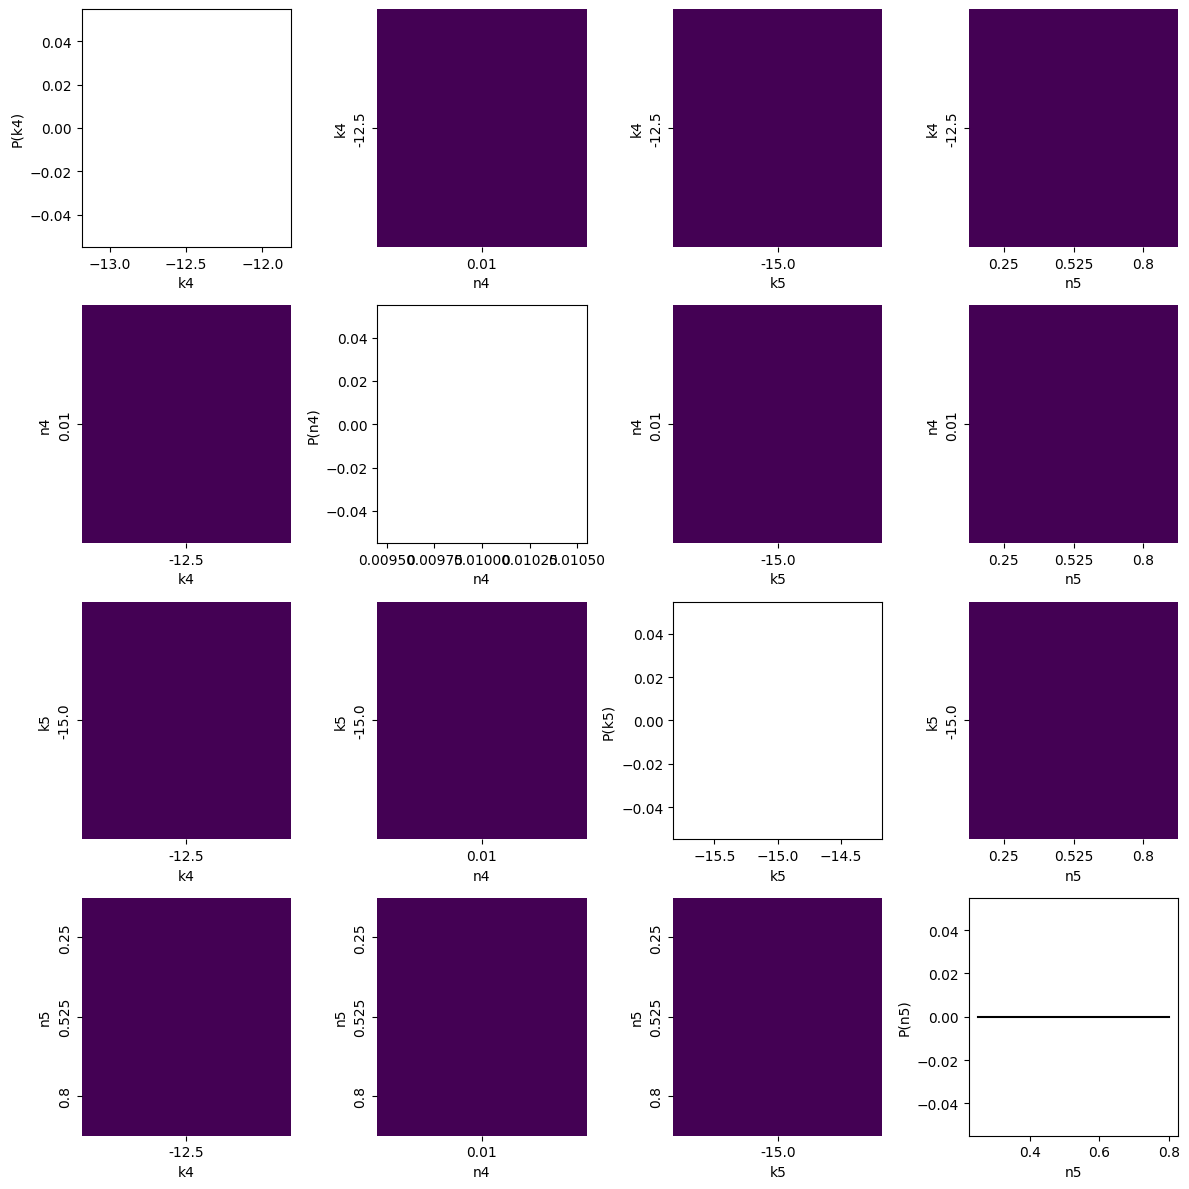

In [20]:
plot_joint_posterior(mse_table, param_cols, param_units=None, cmap="viridis")